# DMD spectogram of slice data

In [1]:
from os import makedirs
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from flowtorch.analysis import DMD, SVD
from utils import normalize_frequency
from flow_conditions import CHORD, A_INF, U_INF

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "./output/naca0012_data/"
output = "./output/naca0012_analysis/slice/"
makedirs(output, exist_ok=True)

In [2]:
times = pt.load(f"{data}slice/times_ref1_z25.pt")
w = pt.load(f"{data}slice/w_ref1_z25.pt").sqrt().unsqueeze(-1)
n_points = w.shape[0]
n_times = times.shape[0]
dm = pt.load(f"{data}slice/dm_ref1_z25.pt")[3*n_points:4*n_points, :] * w

In [3]:
def dmd_spectogram(dm, fs, nperseg, noverlap, dmd_options):
    n_times = dm.shape[1]
    times = pt.arange(0.0, 1/fs*n_times, 1/fs)
    start_at, end_at = 0, nperseg
    freq, integral, bin_time, rank = [], [], [], []
    while end_at <= n_times:
        print(f"\rStarting window {start_at} - {end_at}", end="")
        dmd = DMD(dm[:, start_at:end_at], dt=1.0/fs, **dmd_options)
        sorting = dmd.frequency.argsort()
        freq.append(dmd.frequency[sorting])
        integral.append(dmd.integral_contribution[sorting])
        bin_time.append((times[end_at-1] + times[start_at]) * 0.5)
        rank.append(dmd.svd.rank)
        start_at += nperseg - noverlap
        end_at += nperseg - noverlap
    return freq, integral, bin_time, rank

TOL = 1
def plot_spectrum(freq, integral, bin_time, k, title="", f_bins=20, scale=10.0):
    # extracting dominant frequencies
    f, imp, t = [], [], []
    top_f, top_imp, top_t = [], [], []
    for fi, ii, ti in zip(freq, integral, bin_time):
        f.append(fi[fi > TOL])
        imp.append(ii[fi > TOL])
        t.append(pt.ones(f[-1].shape[0]) * ti * U_INF / CHORD)
        top_k = imp[-1].argsort(descending=True)[:k]
        top_f.append(f[-1][top_k])
        top_imp.append(imp[-1][top_k])
        top_t.append(pt.ones(top_f[-1].shape[0]) * ti * U_INF / CHORD)
    f, imp, t, top_f, top_imp, top_t = [pt.cat(i, dim=0) for i in (f, imp, t, top_f, top_imp, top_t)]
    imp /= imp.max()
    top_imp /= top_imp.max()
    # creating axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.8
    spacing = 0.01
    box_scatter = [left, bottom, width, height]
    box_hist = [left + width + spacing, bottom, 0.2, height]
    fig = plt.figure(figsize=(6, 4))
    ax1 = fig.add_axes(box_scatter)
    ax2 = fig.add_axes(box_hist, sharey=ax1)
    # scatter plot
    ax1.scatter(t, normalize_frequency(f), c="C0", marker="o", s=imp*scale)
    ax1.scatter(top_t, normalize_frequency(top_f), c="C3", marker="o", s=top_imp*scale)
    ax1.set_xlim(t.min(), t.max())
    ax1.set_ylim(0, 15)
    ax1.set_xlabel(r"$\tilde{t}_{bin}$")
    ax1.set_ylabel(r"$\tilde{f}$")
    ax1.set_title(title)
    # histogram
    ax2.hist(normalize_frequency(f).numpy(), bins=f_bins, weights=imp.sqrt().numpy(), density=True, orientation='horizontal')
    # ax2.hist(normalize_frequency(f).numpy(), bins=f_bins, density=True, orientation='horizontal')
    ax2.tick_params(axis="y", labelleft=False)
    ax2.set_title(r"$I_i$-weighted PD")

## Varying number of buffet cycles

In [4]:
nperseg = int(n_times * 4.0 / 5.0)
noverlap = int(nperseg*0.99)
nperseg, noverlap

(908, 898)

In [5]:
dt = times[1] - times[0]
dmd_options = {
    "optimal" : True,
    "unitary" : False,
    "tlsq" : False
}

In [6]:
freq1, integral1, bin_time1, rank1 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 220 - 1128

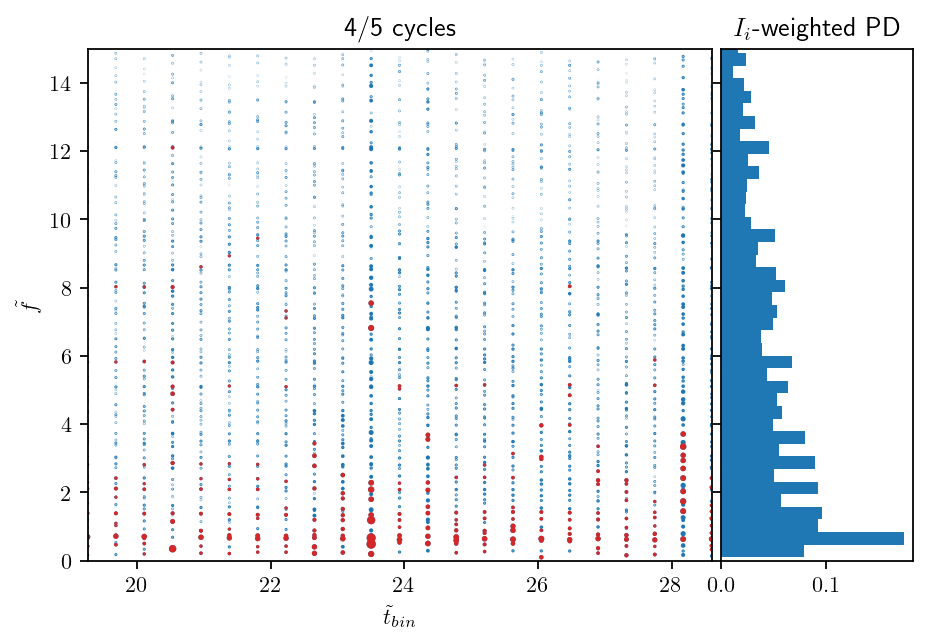

In [7]:
plot_spectrum(freq1, integral1, bin_time1, 10, "4/5 cycles", 200)
plt.savefig(f"{output}f_bin_4cycles_rho.png")
plt.show()

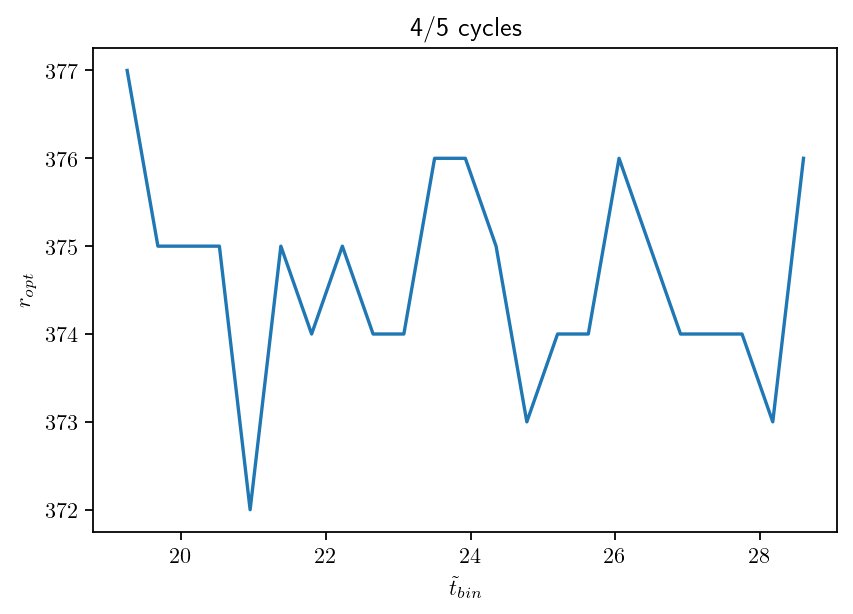

In [8]:
plt.plot(pt.tensor(bin_time1)*U_INF/CHORD, rank1)
plt.xlabel(r"$\tilde{t}_{bin}$")
plt.ylabel(r"$r_{opt}$")
plt.title("4/5 cycles")
plt.show()

In [9]:
nperseg = int(n_times * 3.0 / 5.0)
noverlap = int(nperseg*0.99)
nperseg, noverlap

(681, 674)

In [10]:
freq2, integral2, bin_time2, rank2 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

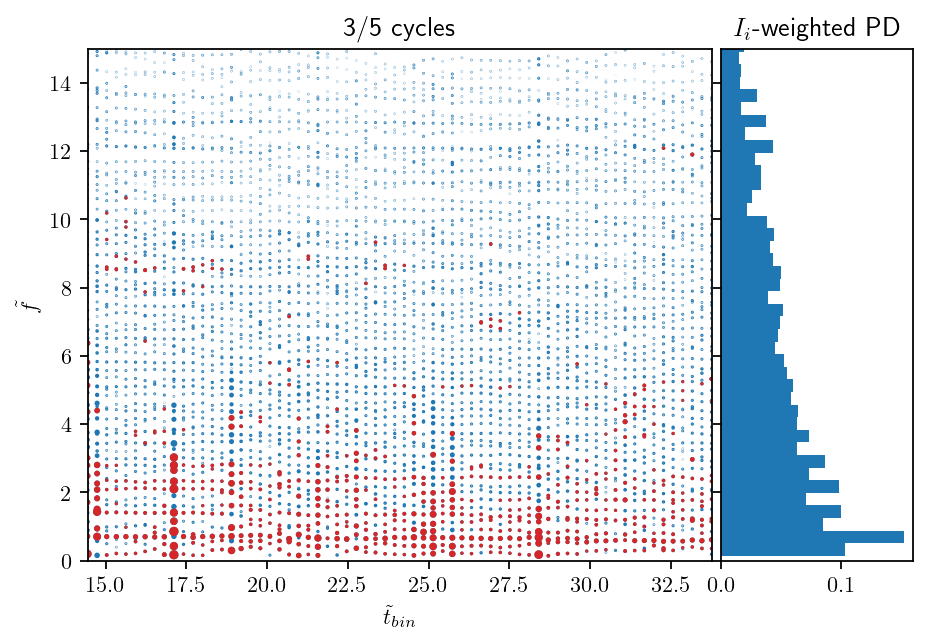

In [11]:
plot_spectrum(freq2, integral2, bin_time2, 10, "3/5 cycles", 200)
plt.savefig(f"{output}f_bin_3cycles_rho.png")
plt.show()

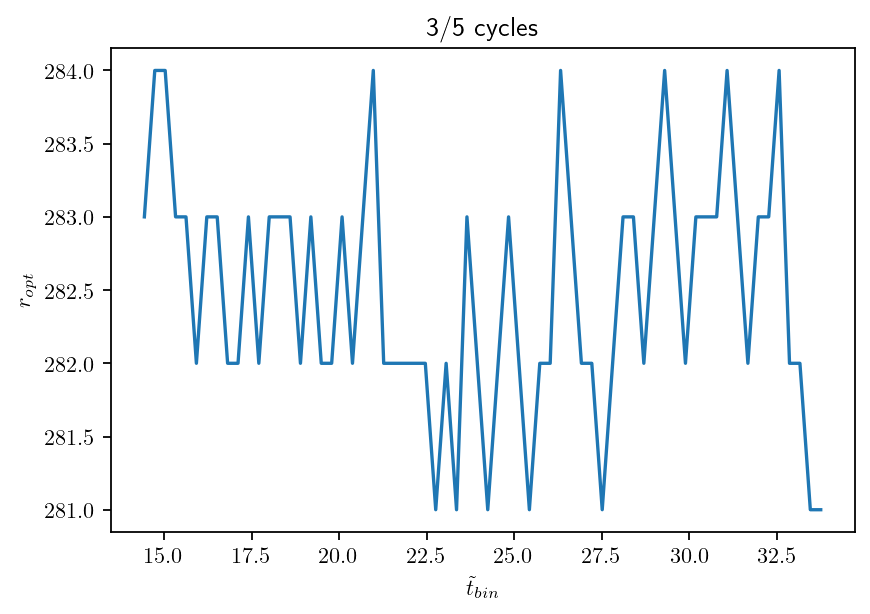

In [12]:
plt.plot(pt.tensor(bin_time2)*U_INF/CHORD, rank2)
plt.xlabel(r"$\tilde{t}_{bin}$")
plt.ylabel(r"$r_{opt}$")
plt.title("3/5 cycles")
plt.show()

In [13]:
nperseg = int(n_times * 2.0 / 5.0)
noverlap = int(nperseg*0.99)
nperseg, noverlap

(454, 449)

In [14]:
freq3, integral3, bin_time3, rank3 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 680 - 1134

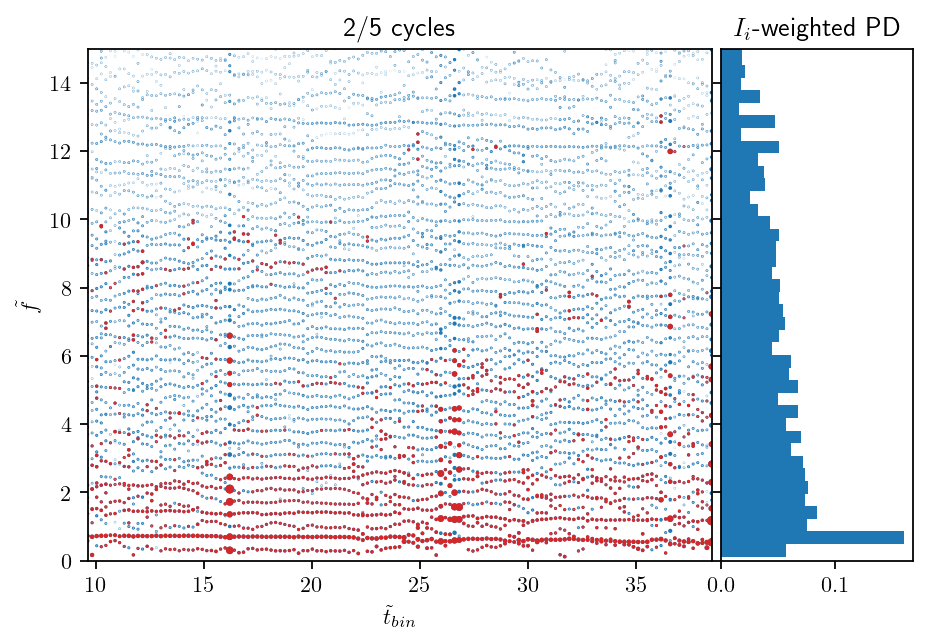

In [15]:
plot_spectrum(freq3, integral3, bin_time3, 10, "2/5 cycles", 200)
plt.savefig(f"{output}f_bin_2cycles_rho.png")
plt.show()

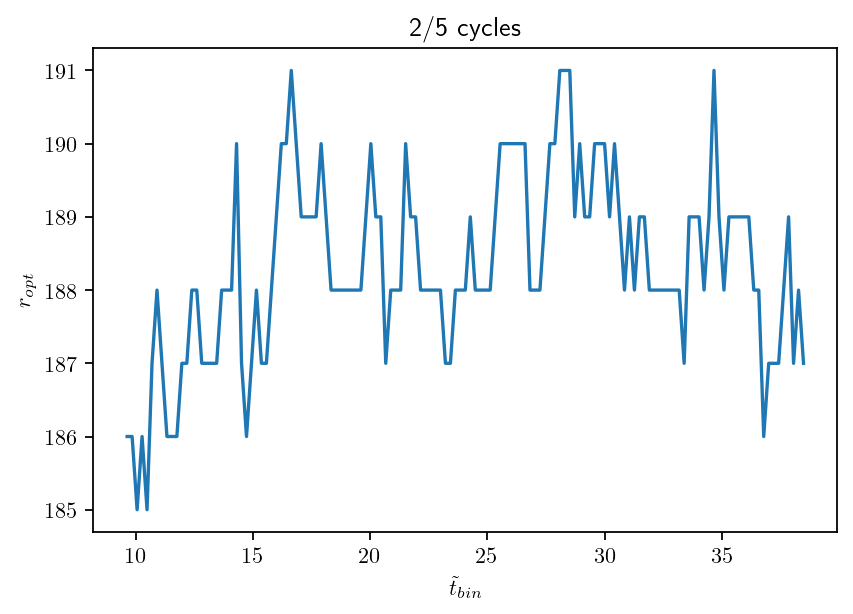

In [16]:
plt.plot(pt.tensor(bin_time3)*U_INF/CHORD, rank3)
plt.xlabel(r"$\tilde{t}_{bin}$")
plt.ylabel(r"$r_{opt}$")
plt.title("2/5 cycles")
plt.show()

## Stronger rank truncation

In [17]:
nperseg = int(n_times * 3.0 / 5.0)
noverlap = int(nperseg*0.99)
nperseg, noverlap

(681, 674)

In [18]:
dmd_options = {
    "optimal" : True,
    "unitary" : False,
    "tlsq" : False,
    "rank" : 50
}

In [19]:
freq4, integral4, bin_time4, rank4 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

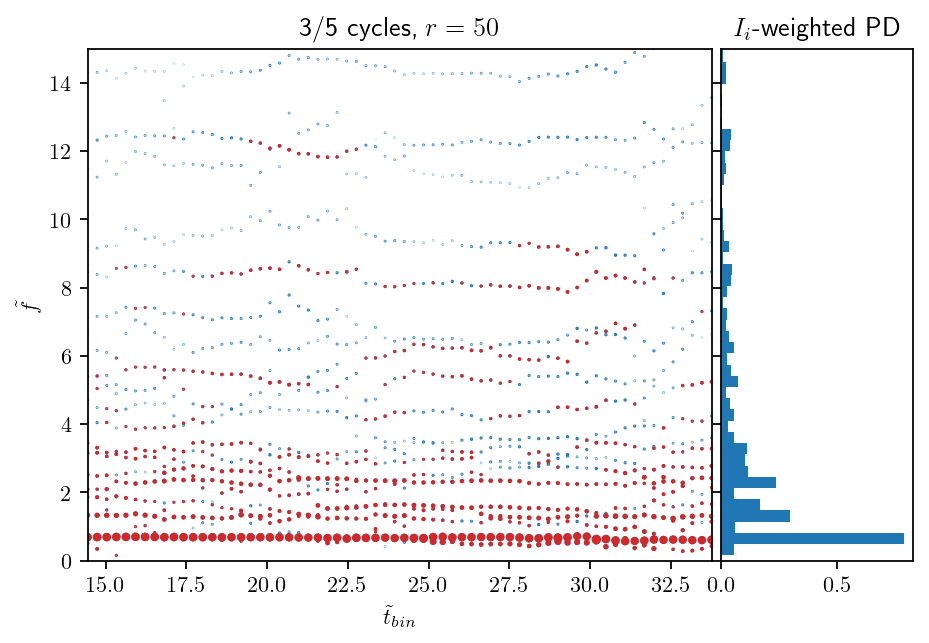

In [20]:
plot_spectrum(freq4, integral4, bin_time4, 10, r"3/5 cycles, $r=50$", 100)
plt.savefig(f"{output}f_bin_3cycles_rho_r50.png")
plt.show()

In [21]:
dmd_options["rank"] = 25

In [22]:
freq5, integral5, bin_time5, rank5 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

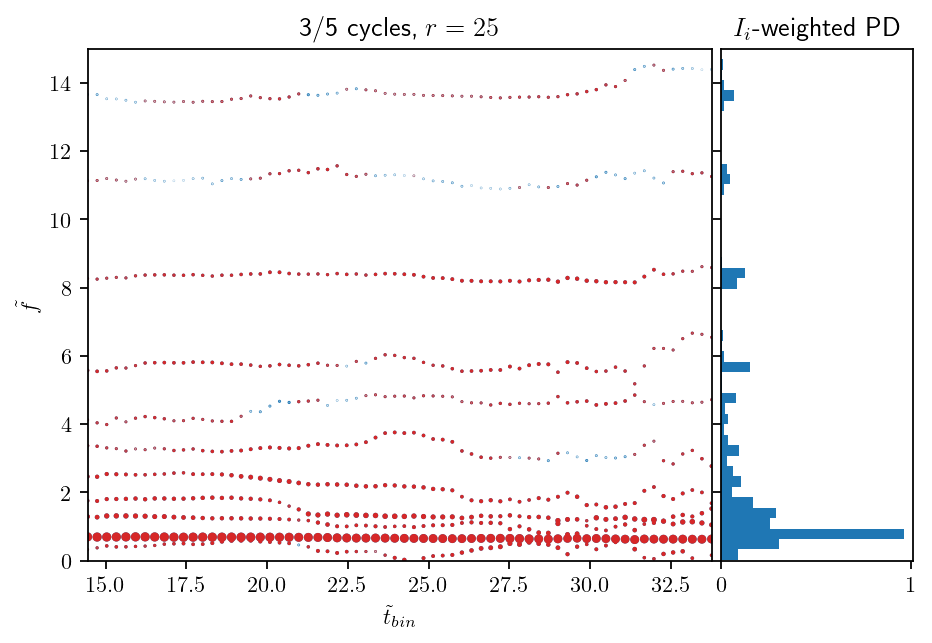

In [23]:
plot_spectrum(freq5, integral5, bin_time5, 10, r"3/5 cycles, $r=25$", 75)
plt.savefig(f"{output}f_bin_3cycles_rho_r25.png")
plt.show()

## Unitary constrained

In [24]:
dmd_options = {
    "optimal" : True,
    "unitary" : True,
    "tlsq" : False,
    "rank" : 50
}

In [25]:
freq6, integral6, bin_time6, rank6 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

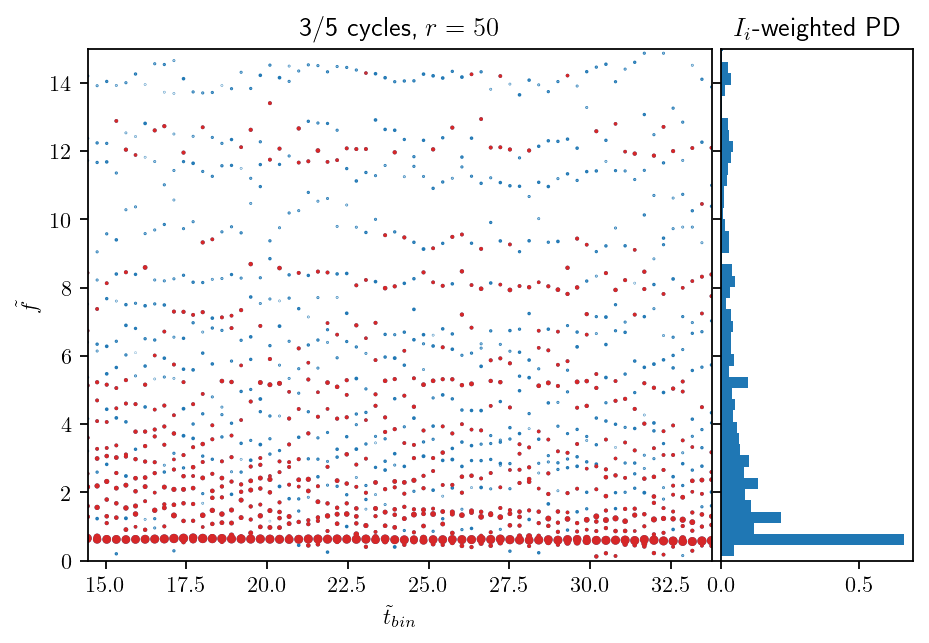

In [26]:
plot_spectrum(freq6, integral6, bin_time6, 10, r"3/5 cycles, $r=50$", 100)
plt.savefig(f"{output}f_bin_3cycles_rho_r50_unitary.png")
plt.show()

In [27]:
dmd_options["rank"] = 25

In [28]:
freq7, integral7, bin_time7, rank7 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

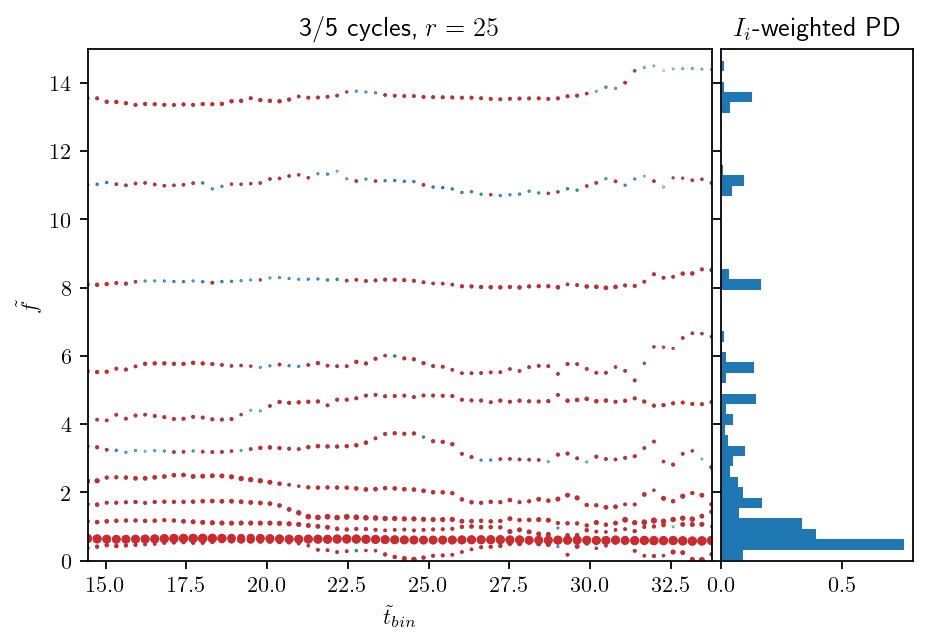

In [29]:
plot_spectrum(freq7, integral7, bin_time7, 10, r"3/5 cycles, $r=25$", 75)
plt.savefig(f"{output}f_bin_3cycles_rho_r25_unitary.png")
plt.show()

## Unitary constrained and modified state vector

In [30]:
## velocity and speed of sound
dm = pt.zeros((3*n_points, n_times))
dm_full = pt.load(f"{data}slice/dm_ref1_z25.pt")
dm[:2*n_points, :] = dm_full[:2*n_points, :] * w.repeat((2, 1))
kappa = pt.tensor(1.4)
scale = pt.sqrt(2.0 / (kappa * (kappa - 1.0)))
U = (dm_full[:n_points, :]**2 + dm_full[n_points:2*n_points, :]**2 + dm_full[2*n_points:3*n_points, :]**2).sqrt()
Ma = dm_full[4*n_points:, :]
dm[2*n_points:, :] = scale * (U / Ma) * w

In [31]:
dmd_options = {
    "optimal" : True,
    "unitary" : True,
    "tlsq" : False,
    "rank" : 50
}

In [32]:
freq8, integral8, bin_time8, rank8 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

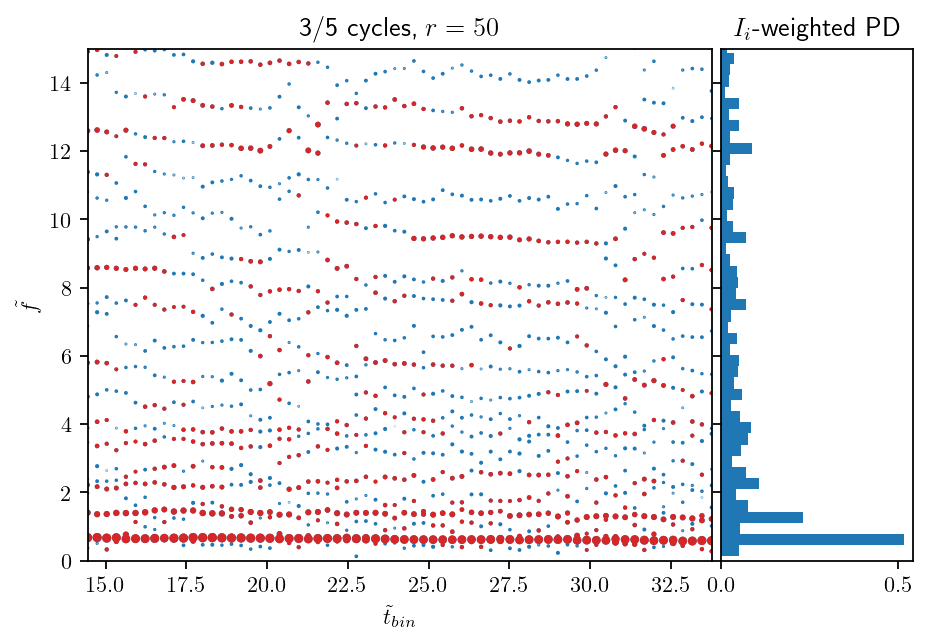

In [33]:
plot_spectrum(freq8, integral8, bin_time8, 10, r"3/5 cycles, $r=50$", 100)
plt.savefig(f"{output}f_bin_3cycles_uxya_r50_unitary.png")
plt.show()

In [34]:
dmd_options["rank"] = 25

In [35]:
freq9, integral9, bin_time9, rank9 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

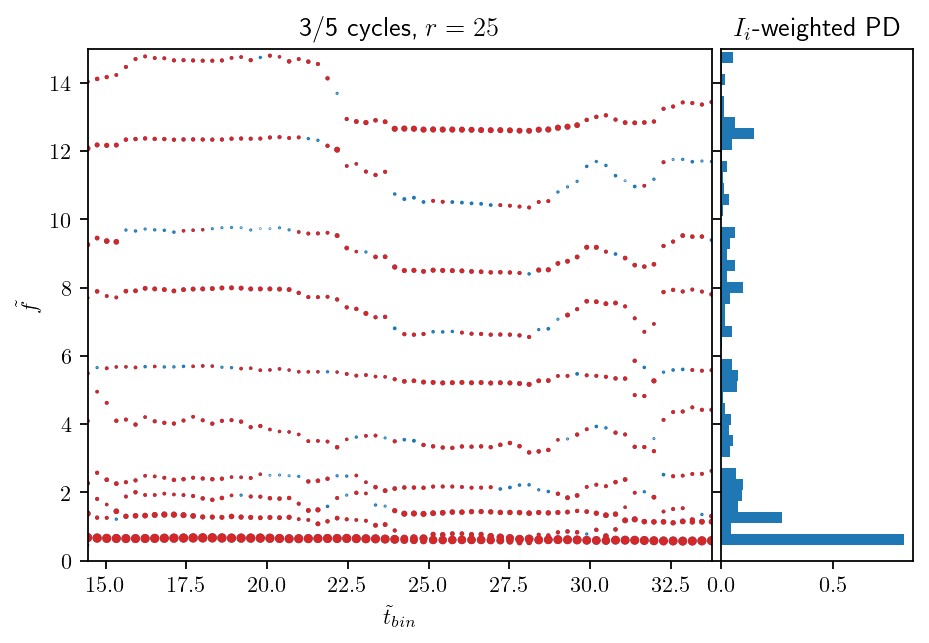

In [36]:
plot_spectrum(freq9, integral9, bin_time9, 10, r"3/5 cycles, $r=25$", 75)
plt.savefig(f"{output}f_bin_3cycles_uxya_r25_unitary.png")
plt.show()

In [37]:
dmd_options = {
    "optimal" : True,
    "unitary" : False,
    "tlsq" : False,
    "rank" : 50
}

In [38]:
freq10, integral10, bin_time10, rank10 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

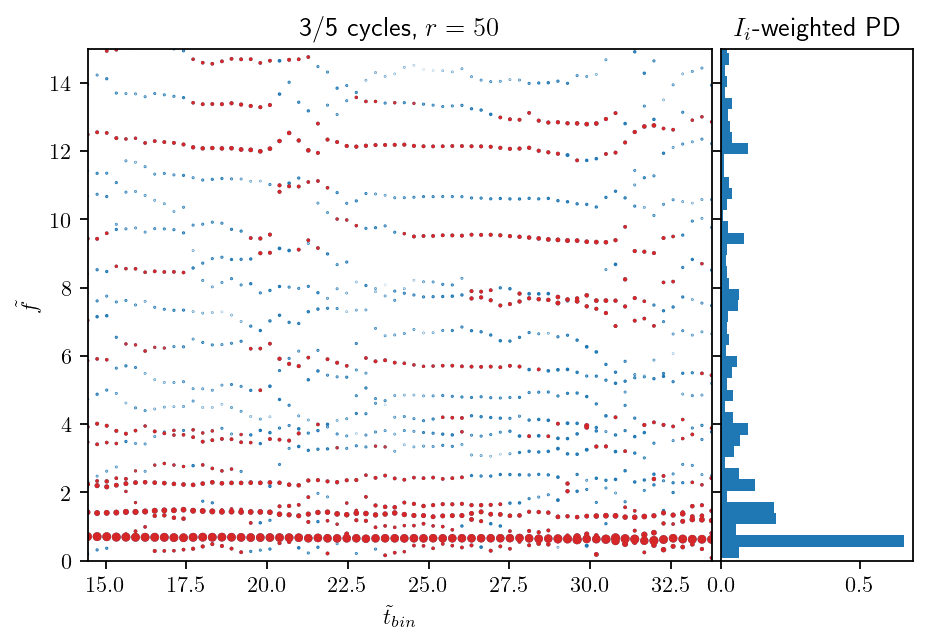

In [39]:
plot_spectrum(freq10, integral10, bin_time10, 10, r"3/5 cycles, $r=50$", 100)
plt.savefig(f"{output}f_bin_3cycles_uxya_r50.png")
plt.show()

In [40]:
dmd_options["rank"] = 25

In [41]:
freq11, integral11, bin_time11, rank11 = dmd_spectogram(dm, 1.0/dt, nperseg, noverlap, dmd_options)

Starting window 455 - 1136

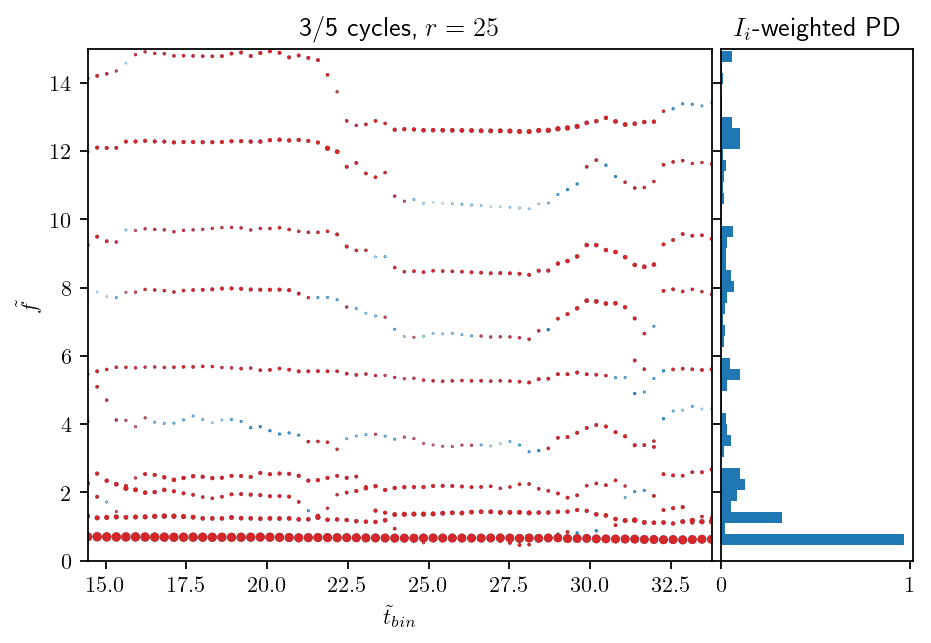

In [42]:
plot_spectrum(freq11, integral11, bin_time11, 10, r"3/5 cycles, $r=25$", 75)
plt.savefig(f"{output}f_bin_3cycles_uxya_r25.png")
plt.show()

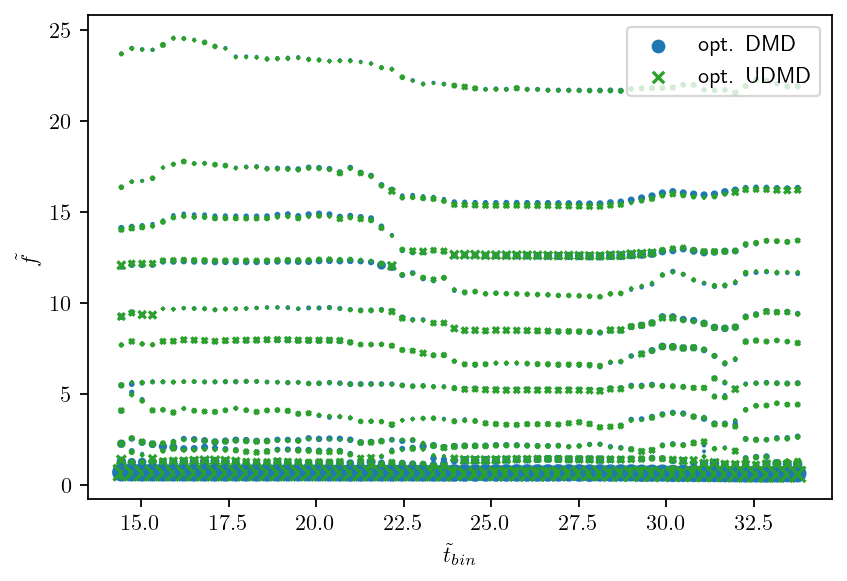

In [43]:
for i, (f9, f11) in enumerate(zip(freq9, freq11)):
    fp9 = f9[f9 > TOL]
    fp11 = f11[f11 > TOL]
    imp9 = integral9[i][f9 > TOL]
    imp11 = integral11[i][f11 > TOL]
    if i == 0:
        plt.scatter(bin_time11[i]*pt.ones(fp11.shape[0])*U_INF/CHORD, normalize_frequency(fp11), c="C0", marker="o", s=imp11*0.1, label="opt. DMD")
        plt.scatter(bin_time9[i]*pt.ones(fp9.shape[0])*U_INF/CHORD, normalize_frequency(fp9), c="C2", s=imp9*0.1, marker="x", label="opt. UDMD")
    else:
        plt.scatter(bin_time11[i]*pt.ones(fp11.shape[0])*U_INF/CHORD, normalize_frequency(fp11), c="C0", marker="o", s=imp11*0.1)
        plt.scatter(bin_time9[i]*pt.ones(fp9.shape[0])*U_INF/CHORD, normalize_frequency(fp9), c="C2", s=imp9*0.1, marker="x")
plt.ylabel(r"$\tilde{f}$")
plt.xlabel(r"$\tilde{t}_{bin}$")
plt.legend()
plt.show()

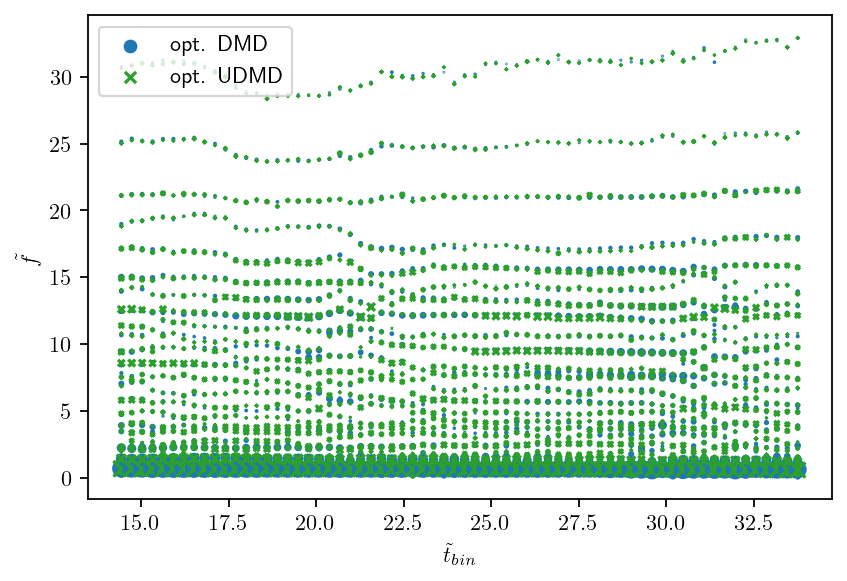

In [44]:
for i, (f8, f10) in enumerate(zip(freq8, freq10)):
    fp8 = f8[f8 > TOL]
    fp10 = f10[f10 > TOL]
    imp8 = integral8[i][f8 > TOL]
    imp10 = integral10[i][f10 > TOL]
    if i == 0:
        plt.scatter(bin_time10[i]*pt.ones(fp10.shape[0])*U_INF/CHORD, normalize_frequency(fp10), c="C0", marker="o", s=imp10*0.1, label="opt. DMD")
        plt.scatter(bin_time8[i]*pt.ones(fp8.shape[0])*U_INF/CHORD, normalize_frequency(fp8), c="C2", s=imp8*0.1, marker="x", label="opt. UDMD")
    else:
        plt.scatter(bin_time10[i]*pt.ones(fp10.shape[0])*U_INF/CHORD, normalize_frequency(fp10), c="C0", marker="o", s=imp10*0.1)
        plt.scatter(bin_time8[i]*pt.ones(fp8.shape[0])*U_INF/CHORD, normalize_frequency(fp8), c="C2", s=imp8*0.1, marker="x")
plt.ylabel(r"$\tilde{f}$")
plt.xlabel(r"$\tilde{t}_{bin}$")
plt.legend()
plt.show()